<a href="https://colab.research.google.com/github/ranjanchoubey/human-detection/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Loaded Image](https://github.com/ranjanchoubey/human-detection/blob/master/assets/image.png?raw=1)

### **Project Presentation**
The detailed project presentation can be accessed through the following link:
- **Link:** [Human Detection Project Presentation](https://docs.google.com/presentation/d/1ebIDe_9QLxQUTOizuFgAEadjVxefgUBD/edit?usp=drive_link&ouid=102222658965169638537&rtpof=true&sd=true)
- **Contents:**
  - Technical approach and methodology
  - Implementation details of HOG and SVM
  - Performance metrics and results
  - Live demonstration examples
  - Future improvements and applications



# **Human Detection using HOG and SVM**

- This project focuses on detecting humans in images using Histogram of Oriented Gradients (HOG) for feature extraction and Support Vector Machine (SVM) for classification.
    The process involves several steps, including importing necessary libraries, defining a sliding window function to scan the image, training the SVM model with positive and negative samples, and finally, applying the trained model to detect humans in new images.

    The project utilizes various Python libraries such as OpenCV, scikit-image, scikit-learn, and matplotlib for image processing, feature extraction, machine learning, and visualization.




## Step1 : Importing Libraries
- We begin by importing the necessary libraries for image processing, feature extraction, machine learning, and visualization. These include OpenCV for image handling, scikit-image for feature extraction, scikit-learn for machine learning, and matplotlib for visualization.

In [1]:
! git clone https://github.com/ranjanchoubey/human-detection/

Cloning into 'human-detection'...
remote: Enumerating objects: 6729, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 6729 (delta 4), reused 16 (delta 4), pack-reused 6712 (from 1)
Receiving objects: 100% (6729/6729), 131.72 MiB | 23.26 MiB/s, done.
Resolving deltas: 100% (204/204), done.
Updating files: 100% (6580/6580), done.


In [2]:
# Human Detection using HOG and SVM

## Importing Libraries
import numpy as np
import cv2
import joblib
import glob
import os
from skimage.feature import hog
from skimage import color
from skimage.transform import pyramid_gaussian
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt

## Step2 : Sliding Window Function

- We have defines a function sliding_window that generates sliding windows over an image. The function takes an image, a window size, and a step size as inputs. It yields the coordinates and the sub-region of the image for each window, which is crucial for scanning the image at different locations to detect objects.


In [3]:
## Sliding Window Function

def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

## Step3 : Training the SVM Model
 - Here, we prepare the training data by loading positive and negative samples, extracting HOG features, and training an SVM model. The positive samples contain images of humans, while the negative samples contain images without humans. The trained model is then saved for later use in detection.

In [4]:
## Training the SVM Model

# Paths to the positive and negative image datasets
pos_im_path = 'human-detection/dataset/positive/'
neg_im_path = 'human-detection/dataset/negative/'
model_path = 'human-detection/models/models.dat'

# Prepare training data
train_data = []
train_labels = []

# Load positive samples
for filename in glob.glob(os.path.join(pos_im_path, "*.png")):
    fd = cv2.imread(filename, 0)
    fd = cv2.resize(fd, (64, 128))
    fd = hog(fd, orientations=9, pixels_per_cell=(8, 8), visualize=False, cells_per_block=(3, 3))
    train_data.append(fd)
    train_labels.append(1)

# Load negative samples
for filename in glob.glob(os.path.join(neg_im_path, "*.jpg")):
    fd = cv2.imread(filename, 0)
    fd = cv2.resize(fd, (64, 128))
    fd = hog(fd, orientations=9, pixels_per_cell=(8, 8), visualize=False, cells_per_block=(3, 3))
    train_data.append(fd)
    train_labels.append(0)

train_data = np.float32(train_data)
train_labels = np.array(train_labels)

# Train the SVM model
model = LinearSVC()
model.fit(train_data, train_labels)
joblib.dump(model, model_path)
print(f'Model saved: {model_path}')

Model saved: human-detection/models/models.dat


## Step4 : Human Detection and Visualization

- W have loaded the trained SVM model and uses it to detect humans in a test image. The image is processed using a sliding window and image pyramid to detect objects at different scales. Detected regions are filtered using non-maximum suppression to remove overlapping detections. Finally, the results are visualized by drawing bounding boxes around detected humans.


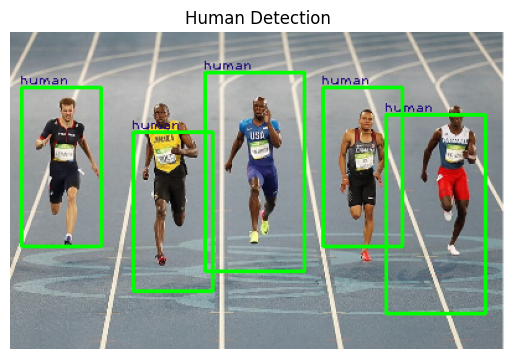

In [5]:
## Human Detection and Visualization

# Load the trained model
model = joblib.load(model_path)

# Load and preprocess the test image
image = cv2.imread('human-detection/assets/bolt.jpg')
image = cv2.resize(image, (400, 256))
size = (64, 128)
step_size = (9, 9)
downscale = 1.25

# List to store detections
detections = []
scale = 0

# Perform detection using sliding window and pyramid
for im_scaled in pyramid_gaussian(image, downscale=downscale):
    if im_scaled.shape[0] < size[1] or im_scaled.shape[1] < size[0]:
        break
    for (x, y, window) in sliding_window(im_scaled, size, step_size):
        if window.shape[0] != size[1] or window.shape[1] != size[0]:
            continue
        window = color.rgb2gray(window)
        fd = hog(window, orientations=9, pixels_per_cell=(8, 8), visualize=False, cells_per_block=(3, 3))
        fd = fd.reshape(1, -1)
        pred = model.predict(fd)
        if pred == 1 and model.decision_function(fd) > 0.5:
            detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fd),
                               int(size[0] * (downscale**scale)), int(size[1] * (downscale**scale))))
    scale += 1

# Apply non-maximum suppression
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
sc = [score[0] for (x, y, score, w, h) in detections]
pick = non_max_suppression(rects, probs=np.array(sc), overlapThresh=0.3)

# Visualize the results
clone = image.copy()
for (x1, y1, x2, y2) in pick:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(clone, 'human', (x1-2, y1-2), 1, 0.75, (121, 12, 34), 1)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.title('Human Detection')
plt.axis('off')
plt.show()

- In conclusion, we have successfully implemented a human detection system using a trained SVM model.
The system processes an input image, applies a sliding window and image pyramid technique to detect humans,
and uses non-maximum suppression to refine the detected bounding boxes.

- The final result is visualized
with bounding boxes around the detected humans. This approach can be further improved by experimenting
with different feature extraction methods, model parameters, and post-processing techniques.


END
---